# camels script testing - vegetation idices

In [1]:
%matplotlib inline  
import os, sys
import xarray as xr
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.optimize import fsolve

import scripts.utility as util

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)


The Python version: 3.11.9
xarray 2024.6.0


# Reading MODIS landcover and lai
- IGBG land cover class MCD12Q1 (aggregated 600m resolution)
- LAI MOD15A2 (aggregated 600m resolution)

In [2]:
catchment_name = 'camels' # 'CONUS_HUC12' or camels
saveCSV = True
saveNetCDF = True

In [3]:
src_dir = '/glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/ingredient/modis'
mapping_file = f'/glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/scripts/gen_mapping/weight_file/spatialweights_nldas600m_to_{catchment_name}.nc'

# camels
gpkg = '/glade/campaign/ral/hap/mizukami/proj/cmip6_hydro/geospatial/gagesII_671_shp_geogr.gpkg' #HCDN_nhru_final_671.buff_fix_holes.CAMELSandTDX_areabias_fix.simp0.001.level1.gpkg
# CONUS_HUC12
#gpkg = '/glade/campaign/ral/hap/mizukami/proj/cmip6_hydro/geospatial/conus_HUC12_merit_v7b_simplified0.001.gpkg' 

In [4]:
# target catchment attribute
catch_attrs = {
    'CONUS_HUC12': ['HUCIDXint'],
    'camels': ['GAGE_ID']
}

In [5]:
# netcdf header: variable name
nc_var = [
    'landcover',
    'lai',
]

IGBP = {
    1:'Evergreen needleleaf forests',
    2:'Evergreen broadleaf forests',
    3:'Deciduous needleleaf forests',
    4:'Deciduous broadleaf forests',
    5:'Mixed forests',
    6:'Closed shrublands',
    7:'Open shrublands',
    8:'Woody savannas',
    9:'Savannas',
    10:'Grasslands',
    11:'Permanent wetlands',
    12:'Croplands',
    13:'Urban and built-up lands',
    14:'Cropland/natural vegetation mosaics',
    15:'Snow and ice',
    16:'Barren',
    17:'Water bodies',
}

In [6]:
%%time
print(f'Reading MODIS data')
ds = xr.open_dataset(os.path.join(src_dir, f'veg_NLDAS_float.nc')).load()
ds['landcover'] = ds['landcover'].where(ds['landcover']>0, np.nan)
ds['forest']    = ds['landcover'].where((ds['landcover']>=1) & (ds['landcover']<=5), 0)
ds['forest']    = ds['forest'].where(ds['forest']==0, 1)

Reading MODIS data
CPU times: user 6.33 s, sys: 639 ms, total: 6.97 s
Wall time: 7.79 s


In [7]:
## copute root depth at 50 and 99 percentile based on IGBG class

def func(x, a, b, Y):
    return np.exp(a*x) + np.exp(b*x) + 2.0*(Y-1.0)

root_param = {
    1: {'a':6.706, 'b':2.175, 'dr':1.8, 'y05':np.nan, 'y99':np.nan},      # Evergreen needleleaf tree
    2: {'a':7.344, 'b':1.303, 'dr':3.0, 'y05':np.nan, 'y99':np.nan},      # Evergreen broadleaf tree
    3: {'a':7.066, 'b':1.953, 'dr':2.0, 'y05':np.nan, 'y99':np.nan},      # Deciduous needleleaf tree
    4: {'a':5.990, 'b':1.955, 'dr':2.0, 'y05':np.nan, 'y99':np.nan},      # Deciduous broadleaf tree
    5: {'a':4.453, 'b':1.631, 'dr':2.4, 'y05':np.nan, 'y99':np.nan},      # Mixed forest
    6: {'a':6.326, 'b':1.567, 'dr':2.5, 'y05':np.nan, 'y99':np.nan},      # Closed shrubland
    7: {'a':7.718, 'b':1.262, 'dr':3.1, 'y05':np.nan, 'y99':np.nan},      # Open shrubland
    8: {'a':7.604, 'b':2.300, 'dr':1.7, 'y05':np.nan, 'y99':np.nan},      # Woody Savanna
    9: {'a':8.235, 'b':1.627, 'dr':2.4, 'y05':np.nan, 'y99':np.nan},      # Savanna
    10:{'a':10.74, 'b':2.608, 'dr':1.5, 'y05':np.nan, 'y99':np.nan},      # Grassland
    11:{'a':np.nan, 'b':np.nan, 'dr':np.nan, 'y05':np.nan, 'y99':np.nan}, # Permanent wetland
    12:{'a':5.558, 'b':2.614, 'dr':1.5, 'y05':np.nan, 'y99':np.nan},      # Cropland
    13:{'a':5.558, 'b':2.614, 'dr':1.5, 'y05':np.nan, 'y99':np.nan},      # Urban and built-up land
    14:{'a':5.558, 'b':2.614, 'dr':1.5, 'y05':np.nan, 'y99':np.nan},      # Cropland/natural vegetation
    15:{'a':np.nan, 'b':np.nan, 'dr':np.nan, 'y05':np.nan, 'y99':np.nan}, # snow and ice
    16:{'a':4.372, 'b':0.978, 'dr':4.0, 'y05':np.nan, 'y99':np.nan},      # Barren
    17:{'a':np.nan, 'b':np.nan, 'dr':np.nan, 'y05':np.nan, 'y99':np.nan}, # water bodies
}

for lc in root_param.keys():
    if lc== 11 or lc==15 or lc==17:
        continue
    root_param[lc]['y05'] = fsolve(func, -0.1, args=(root_param[lc]['a'], root_param[lc]['b'], 0.5))[0]
    root_param[lc]['y99'] = fsolve(func, -0.1, args=(root_param[lc]['a'], root_param[lc]['b'], 0.99))[0]

In [8]:
%%time
ds['rd05'] = util.map_param(ds['landcover'], root_param, 'y05')
ds['rd99'] = util.map_param(ds['landcover'], root_param, 'y99')

CPU times: user 50.1 s, sys: 846 ms, total: 51 s
Wall time: 54.3 s


In [9]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:    (lat: 4480, lon: 9280, month: 12)
Coordinates:
  * lat        (lat) float64 36kB 25.0 25.01 25.02 25.02 ... 52.98 52.99 53.0
  * lon        (lon) float64 74kB -125.0 -125.0 -125.0 ... -67.02 -67.01 -67.0
  * month      (month) int16 24B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    landcover  (lat, lon) float32 166MB nan nan nan nan nan ... 8.0 8.0 8.0 8.0
    lai        (month, lat, lon) float32 2GB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.1 0.1
    forest     (lat, lon) float32 166MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rd05       (lat, lon) float64 333MB nan nan nan nan ... -0.157 -0.157 -0.157
    rd99       (lat, lon) float64 333MB nan nan nan nan ... -1.701 -1.701 -1.701

## Re-mapping
- Monthly LAI
- Landcover class
- Root depth

In [10]:
%%time
# monthly weighted average
dr_mask = xr.where(np.isnan(ds['lai'].isel(month=0)), 0, 1)
a1 = []
for mon in np.arange(12):
    a1.append(util.regrid_mean(xr.open_dataset(mapping_file), ds.isel(month=mon), dr_mask, ['lai'], verbose=False))
a = xr.concat(a1, dim="month")

CPU times: user 32.2 s, sys: 2.19 s, total: 34.4 s
Wall time: 36.2 s


In [11]:
# weighted average
dr_mask = xr.where(np.isnan(ds['rd05']), 0, 1)
a1 = util.regrid_mean(xr.open_dataset(mapping_file), ds, dr_mask, ['rd05', 'rd99'], verbose=False)
a = xr.merge([a, a1])

In [12]:
# Dominant class
dr_mask = xr.where(np.isnan(ds['landcover']), 0, 1)
a1 = util.regrid_mode(xr.open_dataset(mapping_file), ds, dr_mask, ['landcover'])
a = xr.merge([a, a1])

Averaging areas for 671 polygons: 
-------------------
  averaged landcover


In [13]:
# Forest fraction
dr_mask = xr.where(np.isnan(ds['forest']), 0, 1)
a1 = util.regrid_mean(xr.open_dataset(mapping_file), ds, dr_mask, ['forest'])
a = xr.merge([a, a1['forest'].rename('forest_frac')])

Averaging 1 vriables for 671 polygons: 
-------------------
  averaged forest


In [14]:
a['lai_max'] = a['lai'].max(dim='month')
a['lai_diff'] = a['lai_max'] - a['lai'].min(dim='month')

In [15]:
a['1st_dominant_landcover'] = a['1st_dominant_landcover'].where(a['1st_dominant_landcover']!='N/A', -999).astype(float)
a['1st_dominant_landcover'] = a['1st_dominant_landcover'].where(~np.isnan(a['1st_dominant_landcover']), -999.0).astype(int)

In [16]:
a['2nd_dominant_landcover'] = a['2nd_dominant_landcover'].where(a['2nd_dominant_landcover']!='N/A', -999).astype(float)
a['2nd_dominant_landcover'] = a['2nd_dominant_landcover'].where(~np.isnan(a['2nd_dominant_landcover']), -999.0).astype(int)

In [17]:
a

<xarray.Dataset> Size: 134kB
Dimensions:                          (month: 12, hru: 671)
Coordinates:
  * hru                              (hru) <U8 21kB '01013500' ... '14158500'
Dimensions without coordinates: month
Data variables:
    lai                              (month, hru) float64 64kB 0.4913 ... 0.4544
    rd05                             (hru) float64 5kB -0.2377 ... -0.1753
    rd99                             (hru) float64 5kB -2.288 -2.296 ... -1.817
    1st_dominant_landcover           (hru) int64 5kB 5 5 5 4 5 ... 4 10 10 10 1
    2nd_dominant_landcover           (hru) int64 5kB 14 14 14 5 4 ... 14 1 1 1 5
    1st_dominant_landcover_fraction  (hru) float64 5kB 0.8505 0.8571 ... 0.9619
    2nd_dominant_landcover_fraction  (hru) float64 5kB 0.09061 ... 0.03338
    forest_frac                      (hru) float64 5kB 0.8609 0.9072 ... 0.9938
    lai_max                          (hru) float64 5kB 3.944 4.672 ... 3.498
    lai_diff                         (hru) float64 5kB 3.537 4.052 ... 3.044

## Dataset to Dataframe

In [18]:
var_list = ['forest_frac','lai_max','lai_diff','1st_dominant_landcover','1st_dominant_landcover_fraction','rd05','rd99']
df = a[var_list].to_dataframe()

## Save in csv or netcdf

In [19]:
if saveCSV:
    df.to_csv(f'{catchment_name}_veg.csv', float_format='%g')
if saveNetCDF:
    a.to_netcdf(f'{catchment_name}_veg.nc')

## Plotting

In [20]:
%%time
gdf_camels = util.read_shps([gpkg],catch_attrs[catchment_name])

Finished reading /glade/campaign/ral/hap/mizukami/proj/cmip6_hydro/geospatial/gagesII_671_shp_geogr.gpkg
CPU times: user 3.9 s, sys: 40.6 ms, total: 3.94 s
Wall time: 4.3 s


In [21]:
gdf_camels = gdf_camels.merge(df,left_on=catch_attrs[catchment_name], right_index=True)

In [22]:
df = a[['lai']].to_dataframe().reset_index()
df_pivot = df.pivot(index='hru', columns='month', values='lai')
df_pivot.reset_index(inplace=True)
df_pivot.columns.name = None  # Remove the name of the column index
df_pivot = df_pivot.rename_axis(None, axis=1)  # Remove axis labels
for mon in np.arange(12):
    df_pivot.rename(columns={mon:f'lai{mon+1}'}, inplace=True)

In [23]:
gdf_camels = gdf_camels.merge(df_pivot, left_on=catch_attrs[catchment_name], right_on='hru')

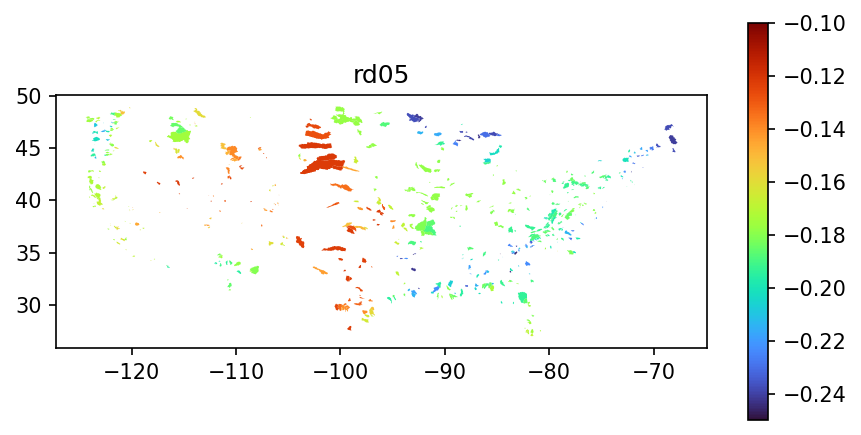

In [24]:
var_name = 'rd05'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
#gdf_camels.plot(ax=ax, color='white', edgecolor='black', lw=0.2)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(-0.25, -0.1),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_veg_{var_name}.png', dpi=300)

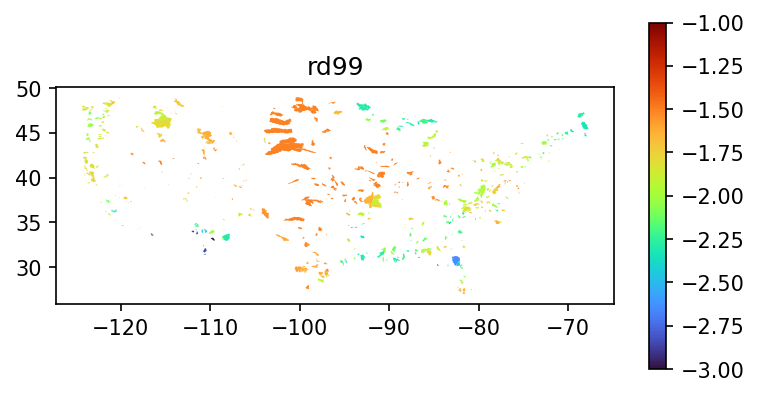

In [25]:
var_name = 'rd99'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
#gdf_camels.plot(ax=ax, color='white', edgecolor='black', lw=0.2)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(-3, -1),
                legend=True
               );
ax.set_title(var_name);
plt.savefig(f'./figures/{catchment_name}_veg_{var_name}.png', dpi=300)

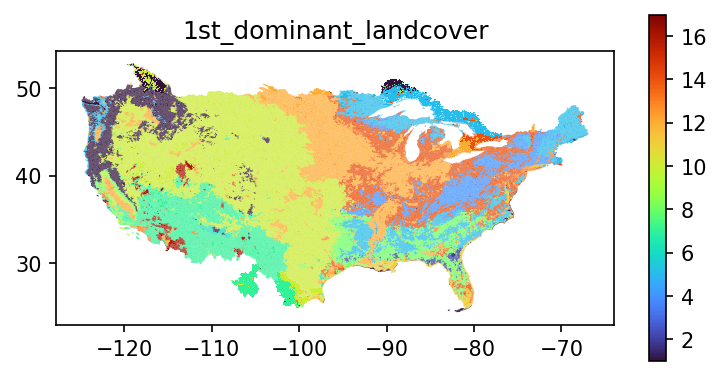

In [24]:
var_name = '1st_dominant_landcover'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
#gdf_camels.plot(ax=ax, color='white', edgecolor='black', lw=0.2)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(1, 17),
                legend=True
               );
ax.set_title(var_name);
plt.savefig(f'./figures/{catchment_name}_veg_{var_name}.png', dpi=300)

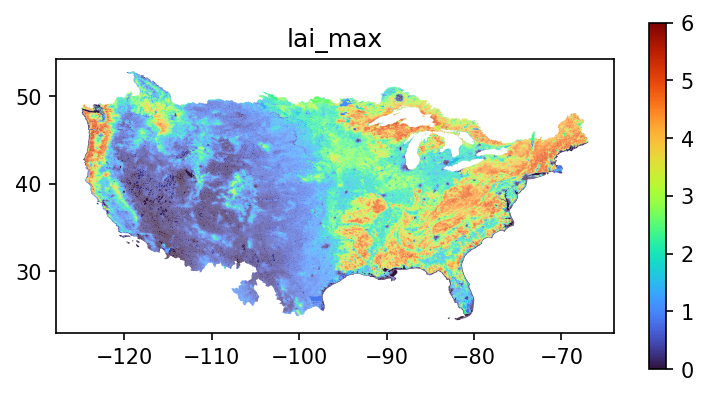

In [27]:
var_name = 'lai_max'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
#gdf_camels.plot(ax=ax, color='white', edgecolor='black', lw=0.2)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(0, 6),
                legend=True
               );
ax.set_title(var_name);
plt.savefig(f'./figures/{catchment_name}_veg_{var_name}.png', dpi=300)

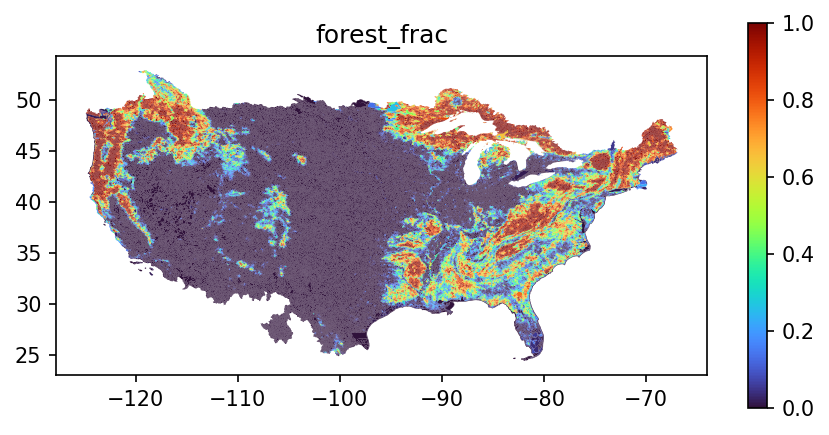

In [28]:
var_name = 'forest_frac'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
#gdf_camels.plot(ax=ax, color='white', edgecolor='black', lw=0.2)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(0, 1),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_veg_{var_name}.png', dpi=300)

## testing

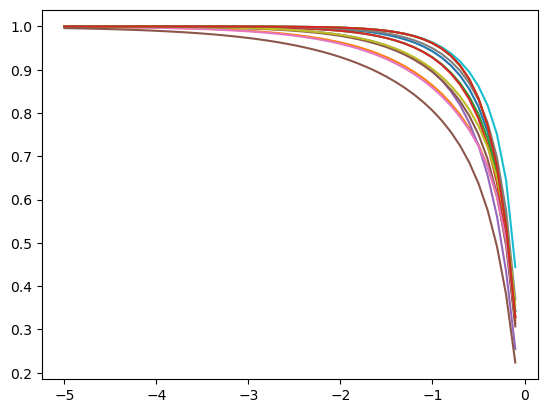

In [71]:
# root depth and cumulative fraction
d = np.arange(-5,0,0.1)
for lc in np.arange(1,18):
    y = 1-0.5*(np.exp(root_param[lc]['a']*d)+np.exp(root_param[lc]['b']*d))
    plt.plot(d, y)

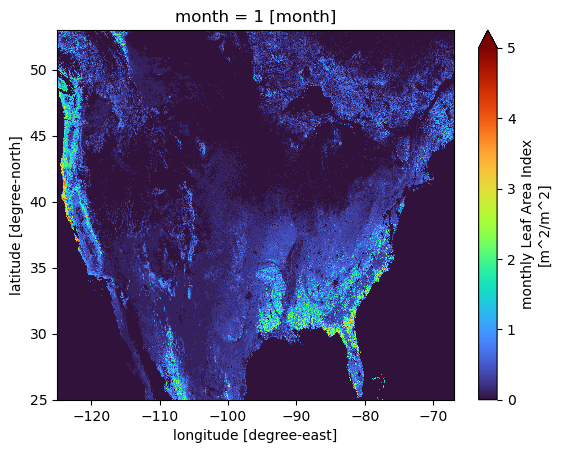

In [32]:
ds['lai'].isel(month=0).plot(cmap='turbo', vmin=0, vmax=5)